In [6]:
import matplotlib.pyplot as plt
import numpy  as np
import pandas as pd
from scipy import optimize
%matplotlib inline
plt.style.use('physics')

plt.rcParams['axes.grid'       ]  = False
plt.rcParams['xtick.labelsize' ]  = 14
plt.rcParams['ytick.labelsize' ]  = 14
plt.rcParams['axes.labelsize'  ]  = 14
plt.rcParams['legend.fancybox' ]  = False

pd.options.mode.chained_assignment = None

import binopt

from scipy import special as sp

def divide( a, b ):
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
#         c[ ~ np.isfinite( c )] = 0
    return c

In [7]:
df = pd.read_hdf('../../data-driven/data/hgg-double-fake-trees-training-2017.h5')

In [29]:
def vbf_presel(data):
    return (
        (data["leadPho_PToM"       ]> (1/3.0))&
        (data["sublPho_PToM"       ]> (1/4.0))&
        (data["dijet_LeadJPt"      ]> 30     )& 
        (data["dijet_SubJPt"       ]> 20     )&
        (data["dijet_Mjj"          ]> 250    )&
        (data["dipho_mass"         ]> 100    )&
        (data["dipho_mass"         ]< 180    ))

df = df[vbf_presel(df)]
df.columns.values

array(['Y', 'Z', 'avg_et', 'avg_pt', 'cr_region', 'diff_et',
       'dijet_LeadJPt', 'dijet_Mjj', 'dijet_SubJPt', 'dijet_Zep',
       'dijet_abs_dEta', 'dijet_dipho_dphi', 'dijet_dipho_dphi_trunc',
       'dijet_dphi', 'dijet_leadEta', 'dijet_minDRJetPho', 'dijet_mva',
       'dijet_subleadEta', 'dipho_PToM', 'dipho_cosphi', 'dipho_leadEt',
       'dipho_leadEta', 'dipho_leadIDMVA', 'dipho_leadPt',
       'dipho_lead_elveto', 'dipho_lead_sieie', 'dipho_mass', 'dipho_mva',
       'dipho_subleadEt', 'dipho_subleadEta', 'dipho_subleadIDMVA',
       'dipho_subleadPt', 'dipho_sublead_elveto', 'dipho_sublead_sieie',
       'eta_cat', 'fail_id', 'isvbf', 'leadPho_PToM', 'lead_eta_cat',
       'm_sideband', 'max_eta', 'max_id', 'min_eta', 'min_id', 'n_jet_30',
       'pass_id', 'sample', 'sublPho_PToM', 'subl_eta_cat', 'weight',
       'weight_bins', 'dijet_centrality_gg', 'dijet_bdt'], dtype=object)

In [30]:
from sklearn.externals import joblib
clf = joblib.load('../../data-driven/notebooks/data-driven-bkg-GBC-training.pkl') 

def evaluate_sklearn(cls, vals, coef=1):
    scale = 1.0 / cls.n_estimators
    ret = np.zeros(vals.shape[0])

    learning_rate = cls.learning_rate
    for itree, t in enumerate(cls.estimators_[:, 0]):
        r = t.predict(vals)
        ret += r * scale
    return 2.0/(1.0 + np.exp(-coef/learning_rate * ret)) - 1

df['dijet_centrality_gg'] = np.exp(-4*(df.dijet_Zep/df.dijet_abs_dEta)**2)
_dijetvar_ = [u'dijet_LeadJPt'  ,u'dijet_SubJPt', 
              u'dijet_abs_dEta' ,u'dijet_Mjj', 
              u'dijet_centrality_gg',u'dijet_dipho_dphi_trunc',
              u'dijet_dphi'     ,u'dijet_minDRJetPho',
              u'leadPho_PToM'   ,u'sublPho_PToM']

df['dijet_bdt'] = evaluate_sklearn(clf,df[_dijetvar_])

In [31]:
df_bkgs = df[
    (df['sample'] != 'data' ) & 
    (df['sample'] != 'qcd'  ) & 
    (df['sample'] != 'vbf'  ) &
    (df['sample'] != 'gjet' ) & 
    (df['sample'] != 'zee'  )
]
df_sign = df[
    (df['sample'] == 'vbf'  )
]

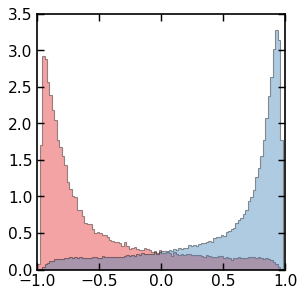

In [32]:
plt.figure(figsize=(4,4))

plt.hist(df_bkgs.dijet_bdt,bins=100, range=[-1,1], 
         alpha=0.4, weights=df_bkgs.weight, 
         histtype='stepfilled',lw=1, normed=1)
plt.hist(df_sign.dijet_bdt,bins=100, range=[-1,1], 
         alpha=0.4, weights=df_sign.weight, 
         histtype='stepfilled',lw=1, normed=1)
# plt.yscale('log')
plt.show()

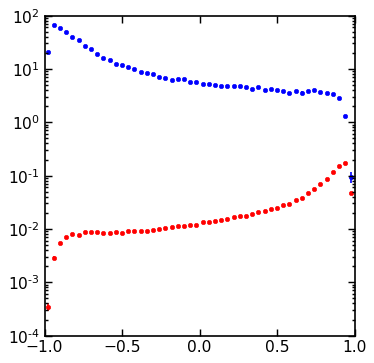

In [33]:
rng = np.random.RandomState(15)  # deterministic random data

s = df_sign.dijet_bdt
b = df_bkgs.dijet_bdt

ms = df_sign.dipho_mass
mb = df_bkgs.dipho_mass

ws = df_sign.weight
wb = df_bkgs.weight

X = np.concatenate([s,b])
Y = np.concatenate([np.ones(s.shape[0]), np.zeros(b.shape[0])])
W = np.concatenate([ws,wb])
M = np.concatenate([ms,mb])


plt.figure(figsize=(5,5))
we_s, x = np.histogram(s, bins=50, range=[-1,1], weights=ws**2)
we_b, _ = np.histogram(b, bins=50, range=[-1,1], weights=wb**2)

he_s, _ = np.histogram(s, bins=50, range=[-1,1], weights=ws)
he_b, _ = np.histogram(b, bins=50, range=[-1,1], weights=wb)

x = np.array([(x[i] + x[i+1])/2.0  for i in range(0,len(x)-1)])
plt.errorbar(x,he_s, yerr=np.sqrt(we_s), fmt='.', c='r', markersize=8, capthick=0)
plt.errorbar(x,he_b, yerr=np.sqrt(we_b), fmt='.', c='b', markersize=8, capthick=0)

plt.yscale('log')
plt.xlim([-1,1])
plt.legend()
plt.show()

In [34]:
help(binopt.optimize_bin)

Help on class optimize_bin in module binopt.core:

class optimize_bin(binner_base)
 |  Optimse bining of lableled data.
 |  
 |  Method resolution order:
 |      optimize_bin
 |      binner_base
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, nbins, range, drop_last_bin=True, fix_upper=True, fix_lower=False, use_kde_density=True)
 |      Init.
 |  
 |  binned_score(self, x, breg=None)
 |      Binned score.
 |  
 |  binned_score_cdf(self, x, breg=None)
 |  
 |  binned_score_density(self, x, breg=None)
 |      Binned score after KDE estimation of the distributions.
 |  
 |  binned_stats(self, x)
 |      Binned score.
 |  
 |  boundary_scan_2d(self, fig=None, title_fmt='.2f', max_n_ticks=5, steps=0.01, label='parameter_scan')
 |      Fit result displayed on matrix.
 |  
 |  cost_fun(self, x, breg=None, lower_bound=None, upper_bound=None)
 |      Cost function.
 |  
 |  covariance_matrix(self)
 |      Covariance matrix.
 |  
 |  fit(self, X, y, sample_weig

In [35]:
binner = binopt.optimize_bin(nbins=3, range=[-1,1], 
                             drop_last_bin=True, fix_upper=True, 
                             fix_lower=False, use_kde_density=False)

In [36]:
help(binner.fit)

Help on method fit in module binopt.core:

fit(self, X, y, sample_weights=None, fom='AMS2', method='TNC', breg=None, min_args={}) method of binopt.core.optimize_bin instance
    Fitting.
    There figure of merits are supported for now :
    AMS1



In [37]:
binner.fit(X, Y, sample_weights=W, method="Nelder-Mead", breg=None, fom="AMS4")

 final_simplex: (array([[ 0.9316,  0.7378,  0.9663],
       [ 0.9317,  0.7378,  0.9663],
       [ 0.9316,  0.7379,  0.9663],
       [ 0.9316,  0.7378,  0.9663]]), array([-0., -0., -0., -0.]))
           fun: -0.0
       message: 'Optimization terminated successfully.'
          nfev: 49
           nit: 10
        status: 0
       success: True
             x: array([ 0.7378,  0.9316,  0.9663])

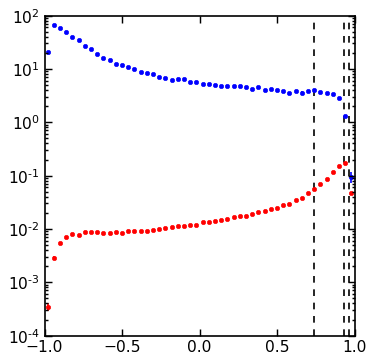

In [38]:
plt.figure(figsize=(5,5))

we_s, x = np.histogram(s, bins=50, range=[-1,1], weights=ws**2)
we_b, _ = np.histogram(b, bins=50, range=[-1,1], weights=wb**2)

he_s, _ = np.histogram(s, bins=50, range=[-1,1], weights=ws)
he_b, _ = np.histogram(b, bins=50, range=[-1,1], weights=wb)

x = np.array([(x[i] + x[i+1])/2.0  for i in range(0,len(x)-1)])
plt.errorbar(x,he_s, yerr=np.sqrt(we_s), fmt='.', c='r', markersize=8, capthick=0)
plt.errorbar(x,he_b, yerr=np.sqrt(we_b), fmt='.', c='b', markersize=8, capthick=0)

# plt.hist(s, bins=50, range=[0,1], weights=ws,
#          color='red' ,histtype='step',lw=1.2, normed=0, label='signal')
# plt.hist(b, bins=50, range=[0,1], weights=wb,
#          color='blue',histtype='step',lw=1.2, normed=0, label='signal')

for x in binner.result.x:
    plt.axvline(x, ls='--', c = 'k')  

plt.yscale('log')
plt.xlim([-1,1])
plt.legend()
plt.show()

In [39]:
print binner.binned_score(binner.result.x)
print binner.binned_stats(binner.result.x)[0]
print binner.binned_stats(binner.result.x)[1]
print binner.binned_stats(binner.result.x)[2]
print binner.binned_stats(binner.result.x)[3]

[ 0.0275  0.1247  0.1636  0.1655]
[ 0.6468  0.5055  0.1427  0.0224]
[  5.6074e+02   1.6277e+01   7.1404e-01   1.2212e-02]
[ 0.0025  0.0022  0.0012  0.0005]
[-1.      0.7378  0.9316  0.9663  1.    ]


KeyboardInterrupt: 

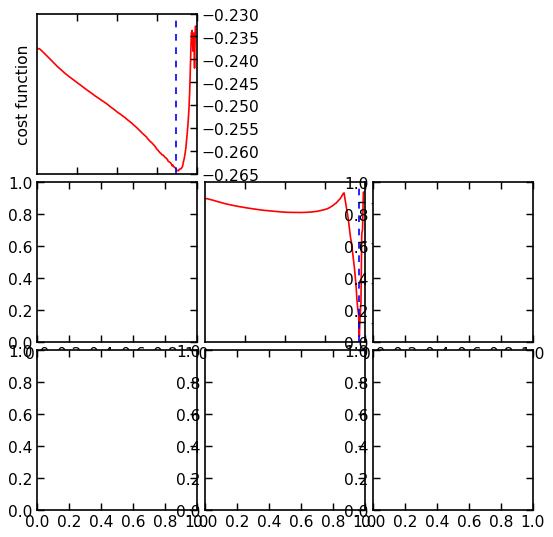

In [40]:
binner.boundary_scan_2d()
plt.show()

## Optimisation of the boundaries using $\sigma_{\rm eff}$ of signla peak

In [21]:
from scipy.stats import norm
from scipy.optimize import minimize
import scipy.stats as st

def binned_score_mgg(bounds, X, y, W, mass, nsig=1):
    """
    Input should contain a resonance of some sort.
    """
    _bounds_ = np.sort(np.insert(bounds, [0, bounds.shape[0]], [binner.range]))
    _cats_ = np.digitize(X, _bounds_)
    _seff_ = np.zeros(_bounds_.shape[0])
    _nums_ = np.zeros(_bounds_.shape[0])
    _numb_ = np.zeros(_bounds_.shape[0])
    _errb_ = np.zeros(_bounds_.shape[0])
    frac = np.abs(norm.cdf(0, -nsig, 1) - norm.cdf(0, nsig, 1))
    for cid in range(1,_bounds_.shape[0]):
        max_, min_ = binopt.tools.weighted_quantile(
            mass[(_cats_ == cid)& (y==1)],
            [norm.cdf(0, -nsig, 1), norm.cdf(0, nsig, 1)],
            sample_weight=W[(_cats_ == cid)& (y==1)])
        
        _seff_[cid] = np.abs(max_-min_)/2.0
        _nums_[cid] = W[(_cats_ == cid) & (y==1)].sum()
        _numb_[cid] = W[(_cats_ == cid) & (y==0)&
                        (mass<max_)&(mass>min_) ].sum()*nsig*_seff_[cid]
        _errb_[cid] = np.sqrt((W[(_cats_ == cid) & (y==0)&
                        (mass<max_)&(mass>min_) ]**2).sum())
#         print "bakground [",cid,"] : ", _errb_[cid]
#     return _errb_
    return binner._fom_(_nums_, _numb_,_errb_, method="AMS4")

def binned_score_fit(bounds, X, y, W, mass, nsig=1):
    """
    Input should contain a resonance of some sort.
    """
    _bounds_ = np.sort(np.insert(bounds, [0, bounds.shape[0]], [binner.range]))
    _cats_ = np.digitize(X, _bounds_)
    _seff_ = np.zeros(_bounds_.shape[0])
    _nums_ = np.zeros(_bounds_.shape[0])
    _numb_ = np.zeros(_bounds_.shape[0])
    _errb_ = np.zeros(_bounds_.shape[0])
    frac = np.abs(norm.cdf(0, -nsig, 1) - norm.cdf(0, nsig, 1))
    
    for cid in range(1,_bounds_.shape[0]):
        def _obj(x):
            out = -np.sum(
                W[(_cats_ == cid) & (y==0)]*st.expon(
                    loc=100, scale=np.exp(x)
                ).logpdf(mass[(_cats_ == cid) & (y==0)])
            )
            if np.isnan(out):
                return 0
            else:
                return out
        _fit = minimize(_obj, x0=[0.03], method='Powell')
        min_, max_ = binopt.tools.weighted_quantile(
            mass[(_cats_ == cid)& (y==1)],
            [norm.cdf(0, -nsig, 1), norm.cdf(0, nsig, 1)],
            sample_weight=W[(_cats_ == cid)& (y==1)])
        
        _seff_[cid] = np.abs(max_-min_)/2.0
        _nums_[cid] = W[(_cats_ == cid) & (y==1)].sum()*frac
        _numb_[cid] = np.abs(
            st.expon(loc=100,scale=np.exp(_fit.x)).cdf(min_)-
            st.expon(loc=100,scale=np.exp(_fit.x)).cdf(max_)
        )
        _errb_[cid] = np.sqrt((W[(_cats_ == cid) & (y==0)]**2).sum()*_numb_[cid])
        _numb_[cid] *= W[(_cats_ == cid) & (y==0)].sum()
    return binner._fom_(_nums_, _numb_,_errb_, method="AMS4")

def cost_fun_mgg(x):
        """Cost function."""
        z = None
        z = binned_score_mgg(x, X, Y, W, M)
        return -np.sqrt((z[1:]**2).sum())
    
def cost_fun_fit(x):
        """Cost function."""
        z = None
        z = binned_score_fit(x, X, Y, W, M)
        return -np.sqrt((z[1:]**2).sum())

In [22]:
print "count : "
print cost_fun_mgg(binner.result.x)
print "fit   : "
print cost_fun_fit(binner.result.x)

count : 
-0.55160227261
fit   : 
-0.561769534216


In [23]:
def cost_mgg_(x):
    return cost_fun_mgg(np.array([x]))

def cost_fit_(x):
    return cost_fun_fit(np.array([x]))

def cost_std_(x):
    return binner.cost_fun(np.array([x]))
cost_mgg_ = np.vectorize(cost_mgg_)
cost_fit_ = np.vectorize(cost_fit_)
cost_std_ = np.vectorize(cost_std_)

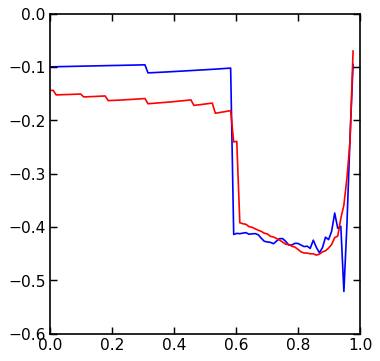

In [24]:
plt.figure(figsize=(5,5))

t = np.linspace(0,X.max(),100)
plt.plot(t, cost_mgg_(t), 'b-')
plt.plot(t, cost_fit_(t), 'r-')
# plt.plot(t, cost_std_(t), 'g-')


# plt.yscale('log')
plt.xlim([0,1])
# plt.ylim([-1.1,-0.7])
plt.legend()
plt.show()

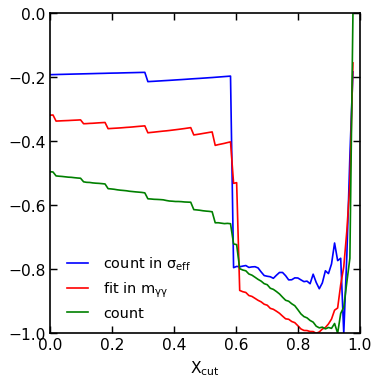

In [25]:
plt.figure(figsize=(5,5))

t = np.linspace(0,X.max(),100)
plt.plot(t, -cost_mgg_(t)/cost_mgg_(t).min(), 'b-', label = "count in $\sigma_{eff}$")
plt.plot(t, -cost_fit_(t)/cost_fit_(t).min(), 'r-', label = "fit in $m_{\gamma\gamma}$")
plt.plot(t, -cost_std_(t)/cost_std_(t).min(), 'g-', label = "count")
# plt.yscale('log')
plt.xlim([0,1])
# plt.ylim([-1.1,-0.7])
plt.xlabel("$X_{cut}$")
plt.legend(loc = "lower left", fontsize=13)
plt.show()

## Bootstraping

In [41]:
from sklearn.model_selection import KFold

n_splits = 100
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

i = 0
for train, test in kf.split(X):
    w_ = W[train] * (W.sum()/W[train].sum())
#     print 'fold[', i ,'] = ',  w_.sum()
    i += 1

In [ ]:
from sklearn.model_selection import KFold

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
t = np.linspace(0.1,0.99,100)

cost_kfold_results = []

i = 0
for train, test in kf.split(X):
    w_ = W[train] * (W.sum()/W[train].sum())
    def cost_kfold_train(x):
        """Cost function."""
        z = None
        z = binned_score_fit(x, X[train], Y[train], 10*W[train], M[train])
        return -np.sqrt((z[1:]**2).sum())

    def cost_kfold_train_(x):
        return cost_kfold_train(np.array([x]))
    cost_kfold_train_= np.vectorize(cost_kfold_train_)
    cost_kfold_results.append(cost_kfold_train_(t))
    
    print 'fold[', i ,'] = ',  w_.sum()
    i += 1   

In [ ]:
mean_score = []
stds_score = []
for h_ in np.array(cost_kfold_results).T:
    mean_score.append(h_.mean())
    stds_score.append(h_.std ())
    
mean_score = np.array(mean_score)
stds_score = np.array(stds_score)

In [ ]:
plt.figure(figsize=(5,5))
# for i in range(0,n_splits)
plt.plot(t, mean_score, 'k-')
plt.fill_between(t, mean_score+stds_score, mean_score-stds_score, alpha=0.5, color='red')
    
plt.xlim([0,1])
plt.ylim([-0.65,-0.45])
plt.xlabel("$X_{cut}$")
plt.legend(loc = "lower left", fontsize=13)
plt.show()

In [ ]:
cv_binner = binopt.optimize_bin(nbins=3, range=[0,1], 
                                drop_last_bin=True, fix_upper=True, 
                                fix_lower=False, use_kde_density=False)

In [ ]:
bounds = []
costfn = []

costfn_stes = []
n_splits = 20
kf = KFold(n_splits=n_splits, shuffle=True, random_state=17)
i = 0
for train, test in kf.split(X):
    print 'fold == ', i
    cv_binner.fit(X[train], Y[train], sample_weights=W[train], breg=None, fom="AMS4")
    bounds.append(cv_binner.result.x  )
    costfn.append(cv_binner.result.fun)
    costfn_stes.append(np.mean(bounds))
    i += 1

In [ ]:
bounds = np.array(bounds)
costfn = np.array(costfn)

In [ ]:
plt.figure(figsize=(5,5))

for u in bounds.T:
    plt.axvline(u.mean(), ls='-', c = 'r')
    plt.axvspan(u.mean() - u.std(),u.mean() + u.std(),facecolor='r',alpha=0.2)  
plt.xlim([0,1])
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(np.cov(bounds.T), interpolation='nearest', 
           cmap=plt.cm.Spectral_r)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(range(len(costfn_stes)),costfn_stes, 'b-')

## Clustering algorithms

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
XY = np.stack([X,Y])
kmeans = KMeans(n_clusters=3, random_state=0).fit(X.reshape(-1,1))

In [ ]:
clus = kmeans.predict(X.reshape(-1,1))

In [ ]:
plt.figure(figsize=(5,5))
for c in np.unique(clus):
    plt.hist(X[clus==c],bins=200, range=[0,1], 
             alpha=1.0, weights=W[clus==c], 
             histtype='step',lw=1, normed=0)
plt.yscale('log')

## Trying another loss function

In the previous version the loss function is defined as $$\mathcal{L}(\theta) = - \sum_{i=0}^{N_{cat}} Z_{i}^2$$

$$\frac{d\mathcal{L}(\theta)}{d b} = \frac{1}{b + s} \left(\log{\left (b \right )} - \log{\left (b + s \right )}\right) - \frac{1}{\left(b + s\right)^{2}} \left(b \log{\left (b \right )} + s \log{\left (s \right )} - \left(b + s\right) \log{\left (b + s \right )}\right)$$

In [ ]:
def binned_cross_entropy(bounds, X, y, W):
    """
    Input should contain a resonance of some sort.
    """
    _bounds_ = np.sort(np.insert(bounds, [0, bounds.shape[0]], [binner.range]))
    _cats_ = np.digitize(X, _bounds_)
    _score_ = np.zeros(_bounds_.shape[0])
    
    for cid in range(1,_bounds_.shape[0]):
        _ns = W[(_cats_ == cid) & (y==1)].sum()
        _nb = W[(_cats_ == cid) & (y==0)].sum()
        
        _vs = W[(_cats_ == cid) & (y==1)].var()
        _vb = W[(_cats_ == cid) & (y==0)].var()
        ps = divide(_ns, np.sqrt(_nb + _ns))
        pb = divide(_nb, np.sqrt(_nb + _ns))
        _score_[cid] = np.sqrt(ps*pb)
    return _score_ 

def entropy_diff_b(s, b):
    term_1 = divide(np.log(b) - np.log(s+b), s+b)
    term_2 = divide(b*np.log(b) + s*np.log(s) - (s+b)*np.log(s+b), (s+b)**2)
    return term_1-term_2

def cost_cross_entropy(x):
        """Cost function."""
        z = None
        z = binned_cross_entropy(x, X, Y, W)
        return np.sqrt((z**2).sum())-1
    
def cost_cross_entropy_(x):
    return cost_cross_entropy(np.array([x]))

cost_cross_entropy_ = np.vectorize(cost_cross_entropy_)

In [ ]:
plt.figure(figsize=(5,5))

t = np.linspace(0.01,0.99,100)
plt.plot(t, -cost_cross_entropy_(t)/cost_cross_entropy_(t).min(), 'b-', label = "Cross-entropy")
plt.plot(t, -cost_std_(t)/cost_std_(t).min(), 'g-', label = "Significance")
plt.xlim([0,1])
plt.ylim([-1.1,-0.7])
plt.xlabel("$X_{cut}$")
plt.legend(loc = "lower left", fontsize=13)
plt.show()

In [ ]:
derive_by_array(lamb, (eta, xi))

In [ ]:
hessian()